3. Consider the Gini index, classifcation error, and entropy in a simple
classifcation setting with two classes. Create a single plot that displays each of these quantities as a function of pˆm1. The x-axis should
display pˆm1, ranging from 0 to 1, and the y-axis should display the
value of the Gini index, classifcation error, and entropy.

Hint: In a setting with two classes, pˆm1 = 1 − pˆm2. You could make
this plot by hand, but it will be much easier to make in R.

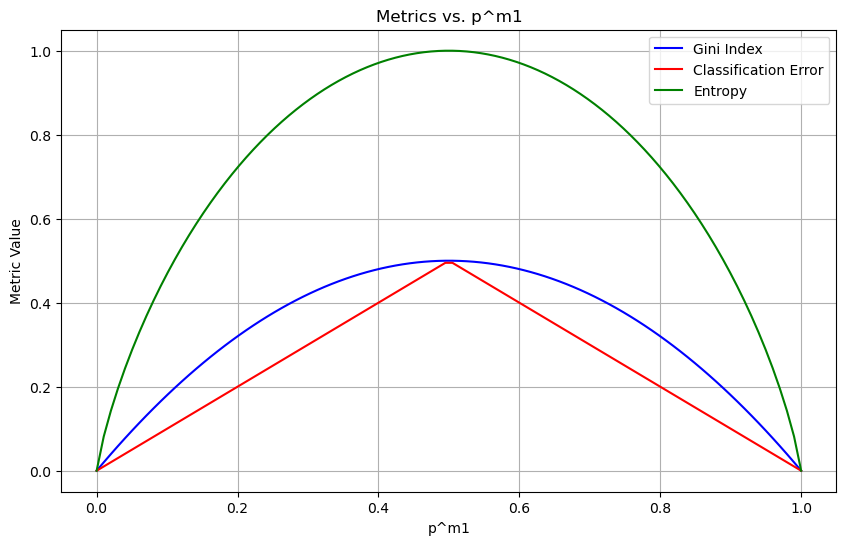

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define functions to calculate Gini index, classification error, and entropy
def gini_index(p_m1):
    return 2 * p_m1 * (1 - p_m1)

def classification_error(p_m1):
    return min(p_m1, 1 - p_m1)

def entropy(p_m1):
    if p_m1 == 0 or p_m1 == 1:
        return 0
    return -p_m1 * np.log2(p_m1) - (1 - p_m1) * np.log2(1 - p_m1)

# Generate p^m1 values
p_m1_values = np.linspace(0, 1, 100)

# Calculate metrics for each p^m1 value
gini_values = np.array([gini_index(p) for p in p_m1_values])
error_values = np.array([classification_error(p) for p in p_m1_values])
entropy_values = np.array([entropy(p) for p in p_m1_values])

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(p_m1_values, gini_values, label='Gini Index', color='blue')
plt.plot(p_m1_values, error_values, label='Classification Error', color='red')
plt.plot(p_m1_values, entropy_values, label='Entropy', color='green')
plt.xlabel('p^m1')
plt.ylabel('Metric Value')
plt.title('Metrics vs. p^m1')
plt.legend()
plt.grid(True)
plt.show()

8. In the lab, a classifcation tree was applied to the Carseats data set af ter converting Sales into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the response as a quantitative variable. (a) Split the data set into a training set and a test set. 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer


carseats = pd.read_csv('C:/Users/nihar/OneDrive/Desktop/Predictive Modeling/Assignments/Carseats.csv')
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [5]:
np.random.seed(14)
# Split the data into features (X) and target variable (y)
X = carseats.drop('Sales', axis=1)
y = carseats['Sales']

# Identify categorical columns
categorical_cols = ['ShelveLoc', 'Urban', 'US']

# One-hot encode categorical columns
ct = ColumnTransformer([('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')
X_encoded = ct.fit_transform(X)


# Split the encoded data into training set (70%) and test set (30%)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_encoded, y, test_size=0.3, random_state=42)


(b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

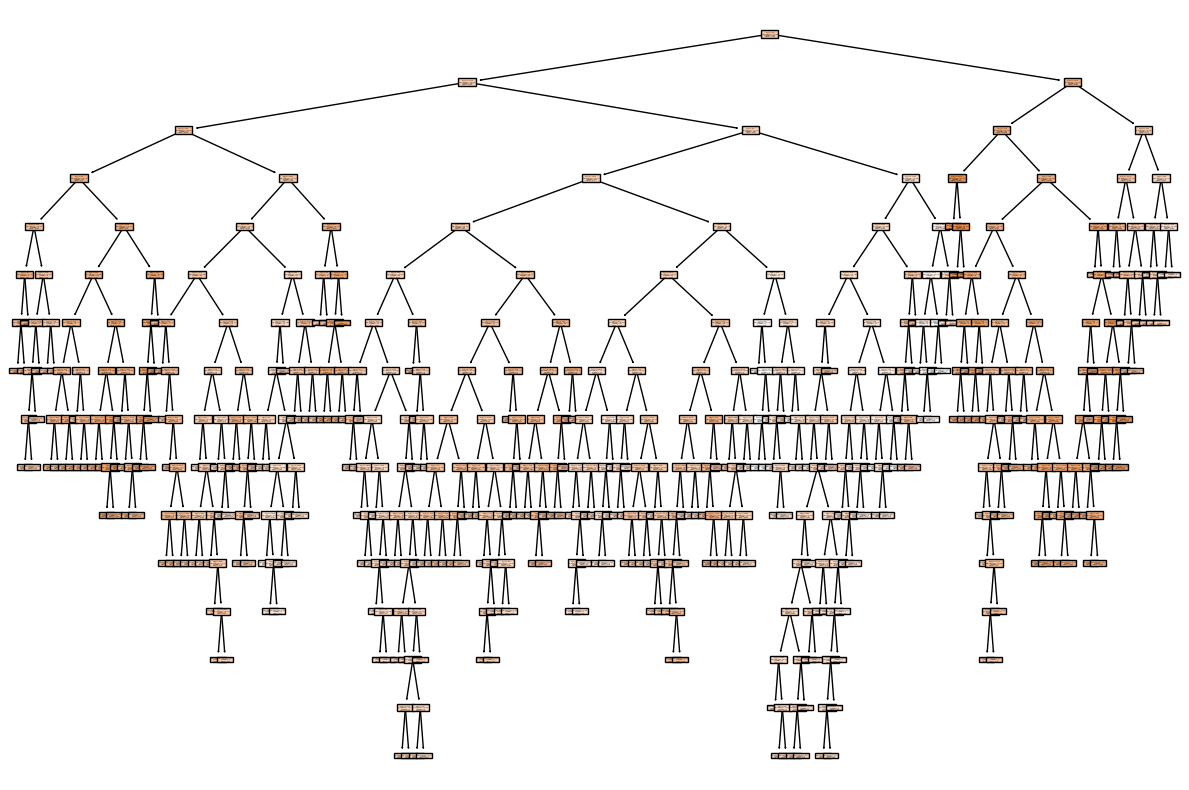

Test MSE with regression tree: 4.754203333333334


In [6]:
reg_tree = DecisionTreeRegressor(random_state=123)
reg_tree.fit(X_train_enc, y_train_enc)

# Plot the tree
plt.figure(figsize=(15, 10))
plot_tree(reg_tree, filled=True)
plt.show()

# Predict on the test set
y_pred = reg_tree.predict(X_test_enc)

# Calculate the test MSE
test_mse = mean_squared_error(y_test_enc, y_pred)
print("Test MSE with regression tree:", test_mse)

(c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE? 

In [7]:
param_grid = {'max_depth': range(1, 11)}
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=123),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)
grid_search.fit(X_train_enc, y_train_enc)
best_tree = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best hyperparameters:", best_params)

# Calculate test MSE with pruned tree
y_pred_pruned = best_tree.predict(X_test_enc)
test_mse_pruned = mean_squared_error(y_test_enc, y_pred_pruned)
print("Test MSE with pruned tree:", test_mse_pruned)


Best hyperparameters: {'max_depth': 5}
Test MSE with pruned tree: 5.278764634133356


(d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the feature_importance_ values to determine which variables are most important.

In [8]:
bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                            n_estimators=100,
                            random_state=123)
bagging.fit(X_train_enc, y_train_enc)

# Predict on the test set using bagging
y_pred_bagging = bagging.predict(X_test_enc)
test_mse_bagging = mean_squared_error(y_test_enc, y_pred_bagging)
print("Test MSE with bagging:", test_mse_bagging)

C:\Users\nihar\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Test MSE with bagging: 2.459217276416666


(e) Use random forests to analyze this data. What test MSE do you obtain? Use the feature_importance_ values to determine which variables are most important. Describe the efect of m, the number of variables considered at each split, on the error rate obtained.

In [9]:
rf = RandomForestRegressor(n_estimators=100, random_state=123)
rf.fit(X_train_enc, y_train_enc)

# Predict on the test set using random forests
y_pred_rf = rf.predict(X_test_enc)
test_mse_rf = mean_squared_error(y_test_enc, y_pred_rf)
print("Test MSE with random forests:", test_mse_rf)

# Feature importance for random forests
importances = rf.feature_importances_
feature_names = ct.get_feature_names_out()
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("Feature importance for random forests:\n", feature_importance)


Test MSE with random forests: 2.4556863249166674
Feature importance for random forests:
                       Feature  Importance
11           remainder__Price    0.325374
1     encoder__ShelveLoc_Good    0.170344
12             remainder__Age    0.113183
7        remainder__CompPrice    0.103701
9      remainder__Advertising    0.076422
0      encoder__ShelveLoc_Bad    0.052303
8           remainder__Income    0.050640
10      remainder__Population    0.042074
13       remainder__Education    0.028550
2   encoder__ShelveLoc_Medium    0.021879
3           encoder__Urban_No    0.004472
5              encoder__US_No    0.004142
4          encoder__Urban_Yes    0.003609
6             encoder__US_Yes    0.003307


(f) Now analyze the data using BART, and report your results.

In [19]:
from ISLP.bart import BART
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

# Assuming 'carseats' is your DataFrame containing the data
X = carseats.drop(columns=['Sales'])
y = carseats['Sales']

# One-hot encode categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[categorical_cols])

# Concatenate the encoded features with the numerical features
X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
X_processed = pd.concat([X.drop(columns=categorical_cols), X_encoded], axis=1)

# Split the data into training and testing sets
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_processed, y, test_size=0.2, random_state=0)

# Initialize the BART estimator
bart_model = BART(burnin=5, ndraw=15, random_state=0)

# Fit the model to the training data
bart_model.fit(X_train_enc.values, y_train_enc.values)

# Make predictions on the testing set
y_pred_bart = bart_model.predict(X_test_enc.values)

# Calculate the test MSE
test_mse_bart = mean_squared_error(y_test_enc, y_pred_bart)
print("Test MSE with BART:", test_mse_bart)

C:\Users\nihar\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Test MSE with BART: 1.7788414783809352


9. This problem involves the OJ data set which is part of the ISLP package. (a) Create a training set containing a random sample of 800 obser vations, and a test set containing the remaining observations.

In [ ]:
import numpy as np
import pandas as pd
import patsy as pt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import HTML
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
import graphviz 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#read in oj file
oj_df=pd.read_csv("oj.csv")

#set random seed
np.random.seed(1)
train_sample=np.random.choice(np.arange(len(oj_df)),size=800,replace=False)
train=np.asarray([(i in train_sample) for i in oj_df.index])

oj_df

(b) Fit a tree to the training data, with Purchase as the response and the other variables as predictors. What is the training error rate? 

In [ ]:
# Use all features excpet response features
# No intercept
f='Purchase ~ + ' + '+'.join(oj_df.columns.drop(['Purchase']))
y,X = pt.dmatrices(f,oj_df)
y=y[:,0]

#fit tree
clf=tree.DecisionTreeClassifier().fit(X[train],y[train])

In [ ]:
#training error rate
1 - clf.score(X[train],y[train])

In [ ]:
clf.tree_.node_count

(c) Create a plot of the tree, and interpret the results. How many terminal nodes does the tree have? 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.design_info.column_names, class_names=['0', '1'], filled=True, rounded=True)
plt.show()

In [ ]:
# Get the number of terminal nodes
terminal_nodes = clf.tree_.n_leaves
print(f"Number of terminal nodes: {terminal_nodes}")

d)Use the export_tree() function to produce a text summary of the ftted tree. Pick one of the terminal nodes, and interpret the information displayed.

In [ ]:
tree_text = tree.export_text(clf, feature_names=X.design_info.column_names)
print(tree_text)

(e) Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?

In [ ]:
# Predict the response on the test data
test = np.logical_not(train)
y_pred = clf.predict(X[test])

# Produce a confusion matrix
conf_matrix = confusion_matrix(y[test], y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the test error rate
test_error_rate = 1 - clf.score(X[test], y[test])
print("Test Error Rate:", test_error_rate)

In [ ]:
#test error rate
1-clf.score(X[~train],y[~train])

(f) Use cross-validation on the training set in order to determine the optimal tree size.

In [ ]:
# Define a range of max_depth values to try
max_depth_values = range(1, 21)

# Perform cross-validation for each max_depth value
cv_scores = []
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(clf, X[train], y[train], cv=5)
    cv_scores.append(scores.mean())

# Find the optimal tree size (max_depth) based on cross-validation scores
optimal_max_depth = max_depth_values[np.argmax(cv_scores)]
print("Optimal Max Depth:", optimal_max_depth)

# Plot the cross-validation scores for each max_depth value
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, cv_scores, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Score vs. Max Depth')
plt.grid(True)
plt.show()

g) Produce a plot with tree size on the x-axis and cross-validated classifcation error rate on the y-axis. 

In [ ]:
# Perform cross-validation for each max_depth value and calculate the classification error rate
cv_error_rates = []
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(clf, X[train], y[train], cv=5, scoring='accuracy')
    error_rate = 1 - scores.mean()
    cv_error_rates.append(error_rate)

# Plot the tree size vs. classification error rate
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, cv_error_rates, marker='o')
plt.xlabel('Tree Size (Max Depth)')
plt.ylabel('Cross-Validated Classification Error Rate')
plt.title('Classification Error Rate vs. Tree Size')
plt.grid(True)
plt.show()

(h) Which tree size corresponds to the lowest cross-validated classification error rate? 

In [ ]:
# Find the tree size (max_depth) corresponding to the lowest cross-validated classification error rate
best_max_depth = max_depth_values[np.argmin(cv_error_rates)]
lowest_error_rate = min(cv_error_rates)

print("Tree Size (Max Depth) with Lowest Error Rate:", best_max_depth)
print("Lowest Cross-Validated Classification Error Rate:", lowest_error_rate)

(i) Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with fve terminal nodes. 

In [ ]:
if best_max_depth in max_depth_values:
    # Use the optimal tree size if it's in the range of max_depth_values
    clf_pruned = tree.DecisionTreeClassifier(max_depth=best_max_depth)
else:
    # If the optimal tree size is not in the range, use max_depth=5
    clf_pruned = tree.DecisionTreeClassifier(max_depth=5)

# Fit the pruned tree on the training data
clf_pruned.fit(X[train], y[train])

# Plot the pruned tree
plt.figure(figsize=(20, 10))
plot_tree(clf_pruned, feature_names=X.design_info.column_names, class_names=['0', '1'], filled=True, rounded=True)
plt.show()

(j) Compare the training error rates between the pruned and un pruned trees. Which is higher? 

In [ ]:
# Fit the unpruned tree on the training data
clf.fit(X[train], y[train])

# Calculate the training error rates for the pruned and unpruned trees
train_error_rate_unpruned = 1 - clf.score(X[train], y[train])
train_error_rate_pruned = 1 - clf_pruned.score(X[train], y[train])

# Create a bar plot for the training error rates
plt.figure(figsize=(8, 6))
plt.bar(['Unpruned Tree', 'Pruned Tree'], [train_error_rate_unpruned, train_error_rate_pruned], color=['blue', 'orange'])
plt.xlabel('Tree Type')
plt.ylabel('Training Error Rate')
plt.title('Comparison of Training Error Rates')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()

Compare the test error rates between the pruned and unpruned trees.pruned Tree is higher.

k) Compare the test error rates between the pruned and unpruned trees. Which is higher

In [ ]:
# Calculate the test error rates for the pruned and unpruned trees
test_error_rate_unpruned = 1 - clf.score(X[test], y[test])
test_error_rate_pruned = 1 - clf_pruned.score(X[test], y[test])
# Create a box plot for the test error rates
# Create a box plot for the test error rates
plt.figure(figsize=(8, 6))
plt.boxplot([[test_error_rate_unpruned], [test_error_rate_pruned]], labels=['Unpruned Tree', 'Pruned Tree'])
plt.ylabel('Test Error Rate')
plt.title('Comparison of Test Error Rates')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()

Compare the test error rates between the pruned and unpruned trees.Unpruned Tree is higher.